<span style="font-size:1.1em;">Colab'a Google drive'ı entegre ediyoruz. Kullanılacak olan veriseti Google Drive'da bulunmaktadır</span>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd 

<span style="font-size:1.1em;">Google Drive'ımızın root pathi</span> ```gdrive/My Drive``` <span style="font-size:1.1em;">oluyor. Proje için gerekli verisetini **mbti** adında bir klasör oluşturup içerisine yüklüyoruz. İlgili verisetinin pathi</span> ```gdrive/My Drive/mbti/all_users.csv``` <span style="font-size:1.1em;">oluyor.</span>

In [0]:
df = pd.read_csv("gdrive/My Drive/mbti/all_users.csv", sep = ';', header = 0) 

In [25]:
df

,user,entry,type,typeClass,E,S,T,J,Unnamed: 8
0,19991991,ekşi itiraf 3,analysts,entj,1,0,1,1,NaN
1,19991991,duygularını belli etmeyen insan modeli bu beni...,analysts,entj,1,0,1,1,NaN
2,19991991,doğum günü resmi olarak kimlikte yazan doğum t...,analysts,entj,1,0,1,1,NaN
3,19991991,kendime not galiba dün akşam siz ne içtiniz de...,analysts,entj,1,0,1,1,NaN
5,19991991,ekşi itiraf vallahi dilinin kemiği yok 50 yaşı...,analysts,entj,1,0,1,1,NaN
...,...,...,...,...,...,...,...,...,...
639116,whiskylife,dursun özbek güya galatasarayın ekonomisini dü...,sentinels,istj,0,1,1,1,NaN
639117,whiskylife,düşün ki o bunu okuyor o kadar özledim ki seni...,sentinels,istj,0,1,1,1,NaN
639119,whiskylife,bağlaç olan de de ayrı yazılır takıntısı gerek...,sentinels,istj,0,1,1,1,NaN
639120,whiskylife,21 ocak 2017 liverpool swensea maçı 23 swansea...,sentinels,istj,0,1,1,1,NaN


In [0]:
import matplotlib.pyplot as plt

<span style="font-size:1.1em;">Verisetinin **class** tiplerine göre dağılım</span>

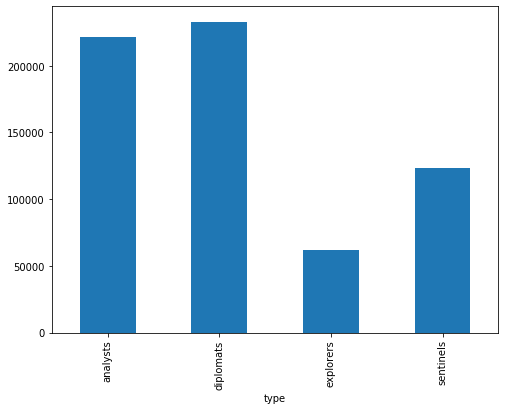

In [6]:
fig = plt.figure(figsize=(8,6))

df.groupby('type').type.count().plot.bar(ylim=0)
plt.show()

<span style="font-size:1.1em;">Verisetindeki **I/E** dağılımını göstermektedir. I olanlar x ekseninde 0 olarak E olanlar ise 1 olarak gösterilmektedir</span>

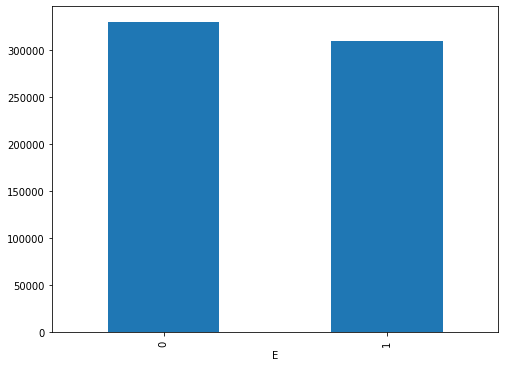

In [7]:
fig = plt.figure(figsize=(8,6))

df.groupby('E').type.count().plot.bar(ylim=0)
plt.show()

<span style="font-size:1.1em;">Verisetindeki **S/N** dağılımını göstermektedir. N olanlar x ekseninde 0 olarak S olanlar ise 1 olarak gösterilmektedir</span>

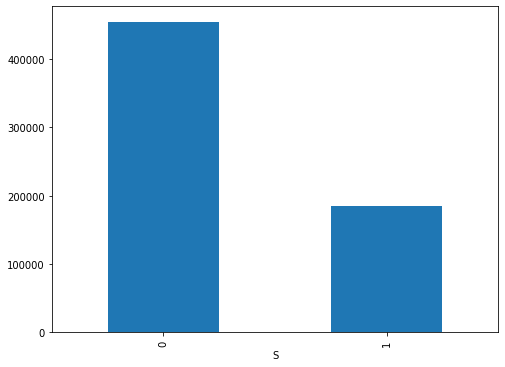

In [8]:
fig = plt.figure(figsize=(8,6))

df.groupby('S').type.count().plot.bar(ylim=0)
plt.show()

<span style="font-size:1.1em;">Verisetindeki **T/F** dağılımını göstermektedir. F olanlar x ekseninde 0 olarak T olanlar ise 1 olarak gösterilmektedir</span>

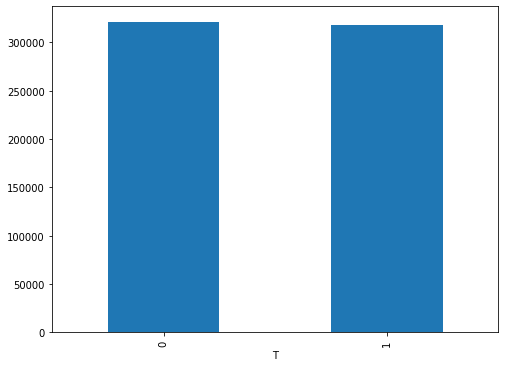

In [9]:
fig = plt.figure(figsize=(8,6))

df.groupby('T').type.count().plot.bar(ylim=0)
plt.show()

<span style="font-size:1.1em;">Verisetindeki **J/P** dağılımını göstermektedir. P olanlar x ekseninde 0 olarak J olanlar ise 1 olarak gösterilmektedir</span>

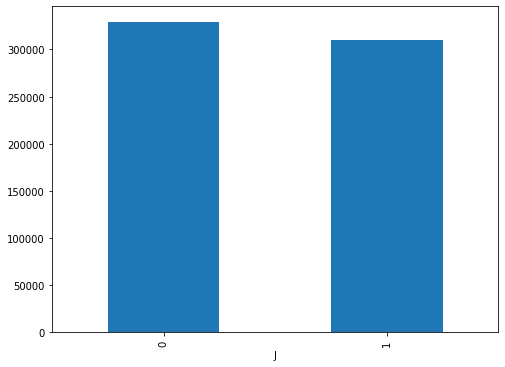

In [10]:
fig = plt.figure(figsize=(8,6))

df.groupby('J').type.count().plot.bar(ylim=0)
plt.show()

Stop words, drive'da /mbti altındaki stop_words_tr.txt okunarak alınır

---



In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
file = open("gdrive/My Drive/mbti/stop_words_tr.txt")
stop_word_list = file.read().split('\n')
file.close()

In [0]:
stop_word_list

Entrylere ön işleme adımları uygulanır. Bu adımlar:


1.   Bütün harflerin küçük harf haline getirilmesi

2.   '**bkz**', '**--- spoiler ---**', '**spoiler**', '**#12341324**' (gibi böyle rakamların devam ettiği) entrylerin verisetinden çıkarılması gerekmektedir.

3. Entrylerden stop words'ler silinmelidir.

4. Web sitelerinin temizlenmesi

5. Noktalama işaretlerinin temizlenmesi

6. Rakamların temizlenmesi

Temizlenme işlemlerinde empty string yerine space (' ') ile replace edilerek yapılmalıdır. Arından da fazla boşluklar vs trim edilmelidir.


Entrylerdeki harfler küçük harf haline getirilir

In [0]:
df['entry'] = df['entry'].str.lower()

Dataframe içerisindeki bütün entrylere 'bkz', 'spoiler', '#' içerip içermediğine bakar ve bunun sonucu index numarasıyla birlikte döner. ```15 True```gibi bu demek oluyor ki 15 numaralı index bizim yazmış olduğumuz koşulu sağlamaktadır.

In [0]:
indexes_contains_unwanted_words = df['entry'].str.contains('|'.join(['bkz', 'spoiler', r'#\d*']))

Dataframe'den ilgili entryler çıkartılır

In [39]:
df = df[~indexes_contains_unwanted_words]
df.shape[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


'ekşi itiraf 3'

Entrylerden stop words silinir.

In [0]:
df['entry'].str.replace('|'.join(stop_word_list), ' ')

Entrylerden web site linkleri silinir.

In [32]:
df['entry'] = df['entry'].replace(r'http\S+', ' ', regex=True, inplace = True).replace(r'www\S+', '', regex=True, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Preprocessing işlemleri yapılır. Burada bir tek Türkçe için stop words listesi kullanılarak girdilerden
gereksiz kelimeler atılır. TF-IDF özellik vektörü çıkarılır.

In [0]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_word_list, max_features=1000)

In [15]:
features = tfidf.fit_transform(df.entry).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lahî'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [16]:
labels = df.type
features.shape

(639124, 1000)

(x, y) -> x: döküman (entry) sayısı, y: kelime (vektör) sayısı
TF-IDF kullanarak çıkartılan özellik vektörü

In [0]:
#pd.set_option('display.max_rows', 20)
#pd.set_option('display.max_columns', 20)
#pd.set_option('display.width', 1000)

#features_df = pd.DataFrame(features)
#features_df

Multinominal Naive Bayes modeli oluşturulur. Oluşturulan bu model verisetinde "type" olarak belirtilen "analysts", "diplomats", "sentimenls", "explorers" sınıflarından hangilerine ait olduğunu tahmin etmek için kullanılır

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['type'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

test_typeClass = y_test.values
   
predictions = clf.predict(count_vect.transform(X_test))

<span style="font-size:1.1em">Yapılacak tahminlerle ilgili istatistiksel verileri tutmak için</span> ```predictions_result```<span style="font-size:1.1em"> adında bir değişken oluşturulur.</span>

<span style="font-size:1.1em">Bu değişkenin yapısı aşağıdaki gibidir.</span>

```json
{
    "predicted": {
        "analysts":  { "actual": {"analysts": 0, "diplomats": 0, "explorers": 0, "sentinels": 0} }
        "diplomats": { "actual": {"analysts": 0, "diplomats": 0, "explorers": 0, "sentinels": 0} }
        "explorers": { "actual": {"analysts": 0, "diplomats": 0, "explorers": 0, "sentinels": 0} }
        "sentinels": { "actual": {"analysts": 0, "diplomats": 0, "explorers": 0, "sentinels": 0} }
    }
}
```

* <span style="font-size:1.1em;">Yapılan tahminlerle ilgili verilere ulaşabilmek için</span>

    ```predictions_results['predicted']```


* <span style="font-size:1.1em;">Yapılan tahminin analyst ise:</span>

    ```predictions_results['predicted']['analysts']``` 


* <span style="font-size:1.1em;">Yapılan analyst tahmininin gerçek değerlerine erişmek için:</span>     

    ```predictions_results['predicted']['analysts']['actual']```  


* <span style="font-size:1.1em;">Test verisi, model tarafından analysts olarak tahmin edilmiştir ve bu verinin gerçek değeri de analysts'tir.</span>

    ```predictions_results['predicted']['analysts']['actual']['analysts']``` 

In [0]:
prediction_results = {'predicted': {}}  ## prediction_result['analysts'] means prediction is 'analysts'

prediction_results['predicted']['analysts']  = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}
prediction_results['predicted']['diplomats'] = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}
prediction_results['predicted']['explorers'] = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}
prediction_results['predicted']['sentinels'] = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}

## prediction_result['analysts']['diplomats'] means prediction is analysts but actual value is diplomats

```prediction_results```<span style="font-size:1.1em"> içerisinde tutulan sayaçların değerleri arttırılır.</span>

In [0]:
for i in range(len(predictions)):
  predicted_value = predictions[i]
  actual_value = test_typeClass[i]
  prediction_results['predicted'][predicted_value]['actual'][actual_value] += 1

<span style="font-size:1.1em">JSON formatına çevrilir </span>```dict``` <span style="font-size:1.1em">tipi. Bu sayede daha okunaklı bir şekilde print edilmiş olur. </span>

In [27]:
import json

print(json.dumps(prediction_results, indent = 2))

{
  "predicted": {
    "analysts": {
      "actual": {
        "analysts": 31693,
        "diplomats": 20280,
        "explorers": 7058,
        "sentinels": 13870
      }
    },
    "diplomats": {
      "actual": {
        "analysts": 23497,
        "diplomats": 37998,
        "explorers": 8341,
        "sentinels": 16902
      }
    },
    "explorers": {
      "actual": {
        "analysts": 0,
        "diplomats": 0,
        "explorers": 11,
        "sentinels": 0
      }
    },
    "sentinels": {
      "actual": {
        "analysts": 17,
        "diplomats": 15,
        "explorers": 5,
        "sentinels": 94
      }
    }
  }
}


<span style="font-size:1.1em;">İlgili field extract edilir</span> ```dict``` <span style="font-size:1.1em;">yapısından.</span>

In [0]:
results = prediction_results['predicted']

<span style="font-size:1.1em;">Başarı oranı hesaplanır</span>

In [29]:
accuracy = (results['analysts']['actual']['analysts'] + results['diplomats']['actual']['diplomats'] + results['explorers']['actual']['explorers'] + results['sentinels']['actual']['sentinels']) / len(predictions)
accuracy

0.43682290134621765

<span style="font-size:1.1em;">**E/I** boyutu tahmin edilir</span>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['E'], random_state = 0)  ## Geri kalanlar S, T, J
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

test_typeClass = y_test.values
   
predictions = clf.predict(count_vect.transform(X_test))

In [39]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
predicted = {}
predicted['I'] = {'actual': {'I': 0, 'E': 0}}
predicted['E'] = {'actual': {'I': 0, 'E': 0}}
predicted

{'E': {'actual': {'E': 0, 'I': 0}}, 'I': {'actual': {'E': 0, 'I': 0}}}

<span style="font-size:1.1em;">Modelin tahminleri 1-0 şeklindedir. 1: evet bu değer demektir. 0: hayır bu değer değil demektir. Verisetinde sütunun ismi E'dir. Eğer ki modelin tahmini E ise 1 değerini verir.</span> ```predicted```<span style="font-size:1.1em">'teki ilgili değere erişebilmek adına </span> ```int_to_class``` <span style="font-size:1.1.em;"> <span style="font-size:1.1em;">array'i kullanılır</span>

In [0]:
int_to_class = ['I', 'E']

for i in range(len(predictions)):
  predicted_value = int_to_class[predictions[i]]
  actual_value = int_to_class[test_typeClass[i]]
  predicted[predicted_value]['actual'][actual_value] += 1


In [42]:
predicted

{'E': {'actual': {'E': 23385, 'I': 10526}},
 'I': {'actual': {'E': 53808, 'I': 72062}}}

In [0]:
accuracy = (predicted['E']['actual']['E'] + predicted['I']['actual']['I']) / len(predictions)

In [44]:
accuracy

0.597361388400373

<span style="font-size:1.1em">**S/N** boyutu tahmin edilir.</span>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['S'], random_state = 0)  ## Geri kalan boyutlar: T, J
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

test_typeClass = y_test.values
   
predictions = clf.predict(count_vect.transform(X_test))

In [0]:
predicted['N'] = {'actual': {'N': 0, 'S': 0}}
predicted['S'] = {'actual': {'N': 0, 'S': 0}}

predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'N': {'actual': {'N': 0, 'S': 0}},
 'S': {'actual': {'N': 0, 'S': 0}}}

In [0]:
int_to_class = ['N', 'S']

for i in range(len(predictions)):
  predicted_value = int_to_class[predictions[i]]
  actual_value = int_to_class[test_typeClass[i]]
  predicted[predicted_value]['actual'][actual_value] += 1

In [0]:
predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'N': {'actual': {'N': 113579, 'S': 46083}},
 'S': {'actual': {'N': 27, 'S': 92}}}

In [0]:
accuracy = (predicted['N']['actual']['N'] + predicted['S']['actual']['S']) / len(predictions)

In [0]:
accuracy

0.71141750270683

<span style="font-size:1.1em">**T/F** boyutu tahmin edilir.</span>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['T'], random_state = 0)  ##  J
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

test_typeClass = y_test.values
   
predictions = clf.predict(count_vect.transform(X_test))

In [0]:
predicted['T'] = {'actual': {'T': 0, 'F': 0}}
predicted['F'] = {'actual': {'T': 0, 'F': 0}}

predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'F': {'actual': {'F': 0, 'T': 0}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'N': {'actual': {'N': 113579, 'S': 46083}},
 'S': {'actual': {'N': 27, 'S': 92}},
 'T': {'actual': {'F': 0, 'T': 0}}}

In [0]:
int_to_class = ['F', 'T']

for i in range(len(predictions)):
  predicted_value = int_to_class[predictions[i]]
  actual_value = int_to_class[test_typeClass[i]]
  predicted[predicted_value]['actual'][actual_value] += 1

In [0]:
predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'F': {'actual': {'F': 39202, 'T': 22159}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'N': {'actual': {'N': 113579, 'S': 46083}},
 'S': {'actual': {'N': 27, 'S': 92}},
 'T': {'actual': {'F': 41155, 'T': 57265}}}

In [0]:
accuracy = (predicted['F']['actual']['F'] + predicted['T']['actual']['T']) / len(predictions)

In [0]:
accuracy

0.6037451261414061

<span style="font-size:1.1em">**J/P** boyutu tahmin edilir.</span>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['J'], random_state = 0) 
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

test_typeClass = y_test.values
   
predictions = clf.predict(count_vect.transform(X_test))

In [0]:
predicted['J'] = {'actual': {'J': 0, 'P': 0}}
predicted['P'] = {'actual': {'J': 0, 'P': 0}}

predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'F': {'actual': {'F': 39202, 'T': 22159}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'J': {'actual': {'J': 0, 'P': 0}},
 'N': {'actual': {'N': 113579, 'S': 46083}},
 'P': {'actual': {'J': 0, 'P': 0}},
 'S': {'actual': {'N': 27, 'S': 92}},
 'T': {'actual': {'F': 41155, 'T': 57265}}}

In [0]:
int_to_class = ['P', 'J']

for i in range(len(predictions)):
  predicted_value = int_to_class[predictions[i]]
  actual_value = int_to_class[test_typeClass[i]]
  predicted[predicted_value]['actual'][actual_value] += 1

In [0]:
predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'F': {'actual': {'F': 39202, 'T': 22159}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'J': {'actual': {'J': 30787, 'P': 19379}},
 'N': {'actual': {'N': 113579, 'S': 46083}},
 'P': {'actual': {'J': 46909, 'P': 62706}},
 'S': {'actual': {'N': 27, 'S': 92}},
 'T': {'actual': {'F': 41155, 'T': 57265}}}

In [0]:
accuracy = (predicted['P']['actual']['P'] + predicted['J']['actual']['J']) / len(predictions)

In [0]:
accuracy

0.5851321496298058

In [0]:
prediction_results['predicted'] = predicted

prediction_results

{'predicted': {'E': {'actual': {'E': 23528, 'I': 10205}},
  'F': {'actual': {'F': 39202, 'T': 22159}},
  'I': {'actual': {'E': 53928, 'I': 72120}},
  'J': {'actual': {'J': 30787, 'P': 19379}},
  'N': {'actual': {'N': 113579, 'S': 46083}},
  'P': {'actual': {'J': 46909, 'P': 62706}},
  'S': {'actual': {'N': 27, 'S': 92}},
  'T': {'actual': {'F': 41155, 'T': 57265}}}}